**Thông tin thành viên:**

- Lê Anh Thư - 21127175
- Nguyễn Nhật Truyền - 21127191
- Nguyễn Minh Đạt - 21127592

<hr/>

# **Nội dung đồ án**
Trong đồ án này, các bạn sẽ làm quen với các mô hình Machine Learning cơ bản trong phân loại văn bản. Nhiệm vụ của các bạn gồm:
1. Phân tách dữ liệu IMDB thành 3 tập train/dev/test và khảo sát tỉ lệ phân chia này.
2. Xây dựng mô hình Decision Tree, Random Forest, SVM, CRF để phân loại văn bản. Trong đó, các câu được biểu diễn bằng TF-IDF với số lượng max-features.

> 2.1 Khảo sát các max-features khác nhau trên cùng một bộ phân tách data ở câu 1

> 2.2 Khảo sát các siêu tham số trong các thuật toán ví dụ Kernel trong SVM, criterion trong Decision Tree, ...

> 2.3 Khảo sát thời gian chạy huấn luyện của các thuật toán
Mỗi so sánh phải thể hiện ở dạng đồ thị và bảng kết quả.

Các nhóm cần trình bày các khảo sát này ở dạng file báo cáo chỉn chu tự thiết kế sao cho đủ các nội dung sau:
1. Bìa báo cáo chứa tiêu ngữ (trường, khoa, bộ môn, môn học), và thông tin thành viên nhóm
2. Mục lục
3. Nội dung các khảo sát: khảo sát nội dung gì, cách tiến hành như thế nào, kết quả ra sao, có nhận xét như thế nào
4. Tài liệu tham khảo





Các code mẫu dưới đây sẽ được cung cấp sẵn

In [ ]:
!pip install nltk scikit-learn

In [ ]:
# Import libraries
import nltk
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import time
import numpy as np

# Visualize
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Download and preprocess IMDb dataset
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# **Download dataset**

In [ ]:
from pathlib import Path
from google_drive_downloader import GoogleDriveDownloader as gdd
DATA_PATH = 'data/imdb_reviews.csv'
if not Path(DATA_PATH).is_file():
    gdd.download_file_from_google_drive(
        file_id='1zfM5E6HvKIe7f3rEt1V2gBpw5QOSSKQz',
        dest_path=DATA_PATH,
    )

In [ ]:
import pandas as pd
imdb_df = pd.read_csv(DATA_PATH)
imdb_df.sample(5)

,review,label
18676,I tend to get furious when hearing about Lucio...,1
37849,this dolph lundgren vehicle is a fun die hard ...,1
29074,I just finished reading a book on Anita Loos' ...,0
6218,This DVD is missing its calling as a Heineken ...,0
24449,I love everything about family guy.<br /><br /...,1


## **Số lượng samples ảnh hưởng nhiều đến thời gian huấn luyện, đây cũng là tham số cần khảo sát**

Yêu cầu về lập trình:
1. Viết code in ra tỉ lệ phân bố các nhãn trong tập dataset con vừa trích xuất
2. Viết code cấu hình để chọn số lượng sample có số nhãn cân bằng

In [ ]:
# Select 10,000 samples from IMDb DataFrame
imdb_df = imdb_df.sample(n=10000, random_state=42)

**Yêu cầu 1: In tỉ lệ phân bố các nhãn trong tập dataset con vừa trích xuất**

In [ ]:
def label_count(imdb_df):
    # Tính tỉ lệ phân bố các nhãn
    label_distribution = imdb_df['label'].value_counts(normalize=True)

    # In ra tỉ lệ phân bố
    print("Tỉ lệ phân bố các nhãn trong tập dữ liệu con:")
    print(label_distribution)

# In tập dataset con vừa trích xuất
label_count(imdb_df)

Tỉ lệ phân bố các nhãn trong tập dữ liệu con:
1    0.5021
0    0.4979
Name: label, dtype: float64


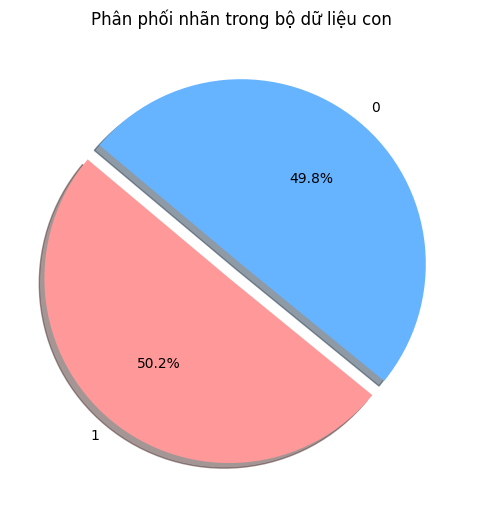

In [ ]:
def visualize_distribution(imdb_df):
    label_distribution = imdb_df['label'].value_counts(normalize=True)

    # Vẽ biểu đồ Pie Chart
    plt.figure(figsize=(6, 6))
    colors = ['#ff9999', '#66b3ff']
    explode = (0.1, 0)
    labels = label_distribution.index
    sizes = label_distribution.values
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title('Phân phối nhãn trong bộ dữ liệu con')
    plt.show()

# Vẽ phân bố tập dataset con vừa trích xuất
visualize_distribution(imdb_df)

**Yêu cầu 2: Cấu hình để chọn số lượng sample có số nhãn cân bằng**

In [ ]:
def balance_dataset(df, label_column='label', random_state=None):
    # Tìm số lượng ít nhất của các nhãn
    min_label_count = df[label_column].value_counts().min()

    # Chọn mẫu từ mỗi nhãn sao cho số lượng là min_label_count
    balanced_samples = []
    for label in df[label_column].unique():
        label_samples = df[df[label_column] == label].sample(n=min_label_count, random_state=random_state)
        balanced_samples.append(label_samples)

    # Tạo DataFrame mới từ các mẫu đã chọn
    balanced_df = pd.concat(balanced_samples, ignore_index=True)

    return balanced_df

# Sử dụng hàm để cân bằng tập dữ liệu con
imdb_balanced_df = balance_dataset(imdb_df, label_column='label', random_state=42)

# In phân bố tập dataset con vừa trích xuất
label_count(imdb_balanced_df)

Tỉ lệ phân bố các nhãn trong tập dữ liệu con:
0    0.5
1    0.5
Name: label, dtype: float64


# **Tiền xử lý dữ liệu**

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import *
import re # regular expression
# Text preprocessing
stop_words = set(stopwords.words('english'))
porter_stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Replace weird characters with spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Tokenization
    words = text.split()

    # Stemming and Lemmatization, and remove stopwords
    words = [porter_stemmer.stem(word) for word in words if word not in stop_words]
    words = [wordnet_lemmatizer.lemmatize(word) for word in words]

    # Join the processed words back into a sentence
    text = ' '.join(words)

    return text

imdb_df['review'] = imdb_df['review'].apply(preprocess_text)

# **Chia tập huấn luyện**
Hiện tại, tỉ lệ đang là 6/2/2 cho train/dev/test. Tuy nhiên, tỉ lệ này cũng cần được khảo sát.

*Vì không sử dụng tập dev nên nhóm em đưa về tỉ lệ train/test = 8/2*

In [ ]:
from sklearn.model_selection import train_test_split
# Split dataset into train/dev/test sets
X_train, X_test, y_train, y_test = train_test_split(imdb_df['review'], imdb_df['label'], test_size=0.2, random_state=42)
#X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [ ]:
print("Size of Train set: ", len(X_train))
#print("Size of Dev set: ", len(X_dev))
print("Size of Test set: ", len(X_test))

Size of Train set:  8000
Size of Test set:  2000


# **Trích xuất đặc trưng biểu diễn câu bằng TF-IDF**
Số lượng đặc trưng tối đa đang sử dụng là 5000, tuy nhiên đây cũng là đặc trưng cần khảo sát

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Convert sentences into TF-IDF representation
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
#X_dev_tfidf = vectorizer.transform(X_dev)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
print("Train shape: ", X_train_tfidf.shape)
#print("Dev shape: ", X_dev_tfidf.shape)
print("Test shape: ", X_test_tfidf.shape)

Train shape:  (8000, 5000)
Test shape:  (2000, 5000)


# **Cài đặt và đánh giá Thuật toán Decision Tree**

In [ ]:
def decision_tree(X_train, y_train, X_test, y_test, **params):
    # Khởi tạo mô hình Decision Tree
    dt_model = DecisionTreeClassifier(random_state=42, **params)

    # Huấn luyện mô hình
    start_time = time.time()
    dt_model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Dự đoán trên tập test
    y_test_pred = dt_model.predict(X_test)

    # Tính độ chính xác
    accuracy = accuracy_score(y_test, y_test_pred)

    return accuracy, training_time

Một số siêu tham số mà chúng ta có thể điều chỉnh để tối ưu hóa hiệu suất của thuật toán Decision Tree:

1. **Criterion (Tiêu chí):**
- 'gini': sử dụng gini impurity
- 'entropy': sử dụng entropy

2. **Max Depth (Độ sâu tối đa):**
- Số nguyên dương hoặc None. Nếu None, cây sẽ mọc cho đến khi mỗi lá chỉ chứa một điểm dữ liệu hoặc đạt đến số lượng mẫu tối thiểu yêu cầu.

3. **Max Features (Số lượng đặc trưng tối đa):**
- None: sử dụng tất cả các đặc trưng
- 'sqrt': sử dụng căn bặc hai của số lượng đặc trưng
- 'log2': sử dụng logarit cơ số 2 của số lượng đặc trưng
- Một số nguyên: số lượng đặc trưng cụ thể

Trong phần này, chúng ta sẽ khảo sát *Max Features* và *Criterion*.

**1. Khảo sát tỉ lệ phân chia  2 tập train/ test với max_features=5000 và criterion='gini'**

In [ ]:
# Khảo sát các tỉ lệ phân chia
split_ratios = [(0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]

results = []

for split_ratio in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(imdb_df['review'], imdb_df['label'], test_size=split_ratio[1], random_state=42)

    X_train_tfidf = vectorizer.transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    accuracy, training_time = decision_tree(X_train_tfidf, y_train, X_test_tfidf, y_test, max_features=5000, criterion='gini')
    results.append({'split_ratio': split_ratio, 'accuracy': accuracy, 'training_time': training_time})

# Hiển thị kết quả dưới dạng bảng
results_ratios_df = pd.DataFrame(results)
results_ratios_df

,split_ratio,accuracy,training_time
0,"(0.5, 0.5)",0.714600,2.042443
1,"(0.6, 0.4)",0.704500,2.646164
2,"(0.7, 0.3)",0.719667,3.299492
3,"(0.8, 0.2)",0.725000,4.448809
4,"(0.9, 0.1)",0.709000,4.745789


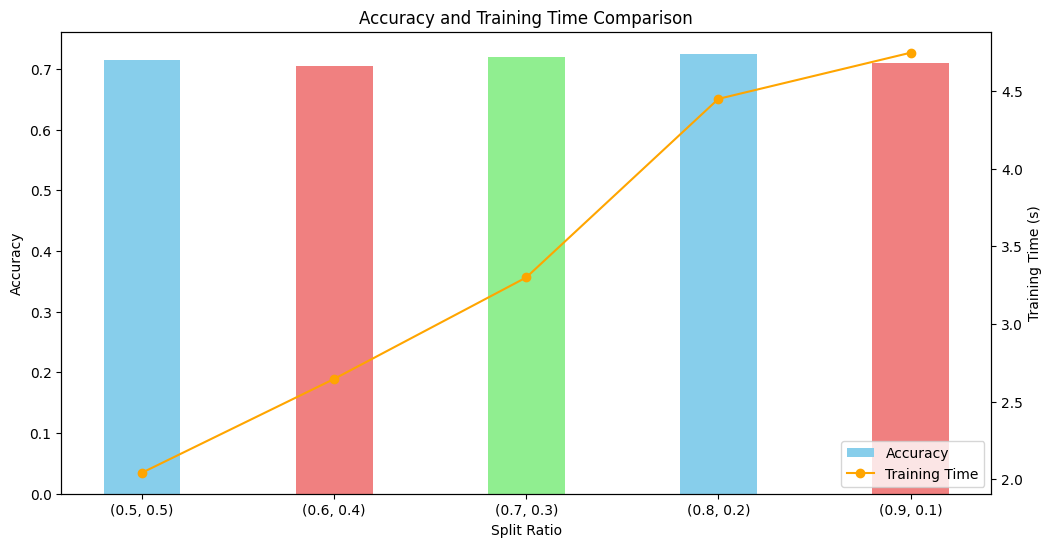

In [ ]:
bar_colors = ['skyblue', 'lightcoral', 'lightgreen']

def ratios_plot(split_ratios, results_ratios_df):
    # Hiển thị kết quả dưới dạng đồ thị
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Vẽ đồ thị cột
    ax1.bar(results_ratios_df.index, results_ratios_df['accuracy'], color=bar_colors, width=0.4, label='Accuracy')
    ax1.set_xlabel('Split Ratio')
    ax1.set_ylabel('Accuracy')
    ax1.tick_params('y')

    # Vẽ đồ thị đường
    ax2 = ax1.twinx()
    ax2.plot(results_ratios_df.index, results_ratios_df['training_time'], color='orange', marker='o', label='Training Time')
    ax2.set_ylabel('Training Time (s)')
    ax2.tick_params('y')

    ax1.set_xticks(results_ratios_df.index)
    ax1.set_xticklabels([str(ratio) for ratio in split_ratios])

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='lower right')

    plt.title('Accuracy and Training Time Comparison')
    plt.show()

ratios_plot(split_ratios, results_ratios_df)

**2. Khảo sát các giá trị của max-features và criterion**

In [ ]:
# Khảo sát các giá trị của max-features và criterion
max_features_values = [500, 1000, 2000, 3000, 4000, 5000]
criterion_values = ['gini', 'entropy']

results = []

for max_features in max_features_values:
    for criterion in criterion_values:
        accuracy, training_time = decision_tree(X_train_tfidf, y_train, X_test_tfidf, y_test, max_features=max_features, criterion=criterion)
        results.append({'max_features': max_features, 'criterion': criterion, 'accuracy': accuracy, 'training_time': training_time})

# Hiển thị kết quả dưới dạng bảng
results_features_df = pd.DataFrame(results)
results_features_df

,max_features,criterion,accuracy,training_time
0,500,gini,0.714,0.592320
1,500,entropy,0.723,0.607684
2,1000,gini,0.727,1.058604
3,1000,entropy,0.721,1.315242
4,2000,gini,0.713,2.691754
5,2000,entropy,0.695,1.924322
6,3000,gini,0.718,2.953921
7,3000,entropy,0.724,2.887714
8,4000,gini,0.737,4.414486
9,4000,entropy,0.727,4.138058


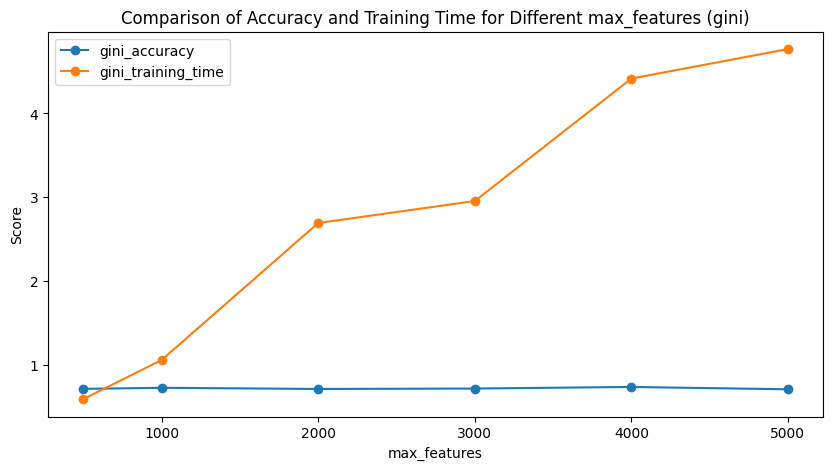

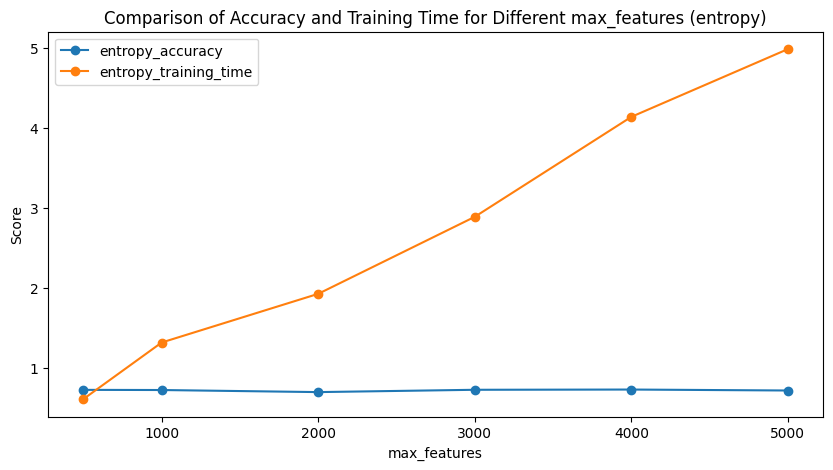

In [ ]:
# Hiển thị kết quả dưới dạng đồ thị
gini_data = results_features_df[results_features_df['criterion'] == 'gini']
entropy_data = results_features_df[results_features_df['criterion'] == 'entropy']

plt.figure(figsize=(10, 5))
plt.plot(gini_data['max_features'], gini_data['accuracy'], label='gini_accuracy', marker='o')
plt.plot(gini_data['max_features'], gini_data['training_time'], label='gini_training_time', marker='o')
plt.title('Comparison of Accuracy and Training Time for Different max_features (gini)')
plt.xlabel('max_features')
plt.ylabel('Score')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(entropy_data['max_features'], entropy_data['accuracy'], label='entropy_accuracy', marker='o')
plt.plot(entropy_data['max_features'], entropy_data['training_time'], label='entropy_training_time', marker='o')
plt.title('Comparison of Accuracy and Training Time for Different max_features (entropy)')
plt.xlabel('max_features')
plt.ylabel('Score')
plt.legend()
plt.show()

# **Cài đặt và đánh giá Thuật toán Random Forest**

In [ ]:
def random_forest(X_train, y_train, X_test, y_test, n_estimators, max_features):
    # Khởi tạo mô hình Decision Tree
    rf_model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, random_state=42)

    # Huấn luyện mô hình
    start_time = time.time()
    rf_model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Dự đoán trên tập phát triển
    y_test_pred = rf_model.predict(X_test)

    # Tính độ chính xác
    accuracy = accuracy_score(y_test, y_test_pred)

    return accuracy, training_time

Một số siêu tham số mà chúng ta có thể điều chỉnh để tối ưu hóa hiệu suất của thuật toán Random Forest:

1. **n_estimators:**
- Số lượng cây quyết định trong ensemble (tổ hợp)
- Ví dụ: `n_estimators=100` (sử dụng 100 cây)

2. **max_features:**
- Số lượng đặc trưng mà mỗi cây quyết định được phép sử dụng để đánh giá tại mỗi nút
- Ví dụ:
  + `max_features='sqrt'` (sử dụng căn bậc hai số lượng đặc trưng)
  + `max_features='log2'` (sử dụng logarit cơ số 2 của số lượng đặc trưng)
  + `max_features=None` (sử dụng tất cả đặc trưng)
  + `max_features=0.8` (sử dụng 80% số lượng đặc trưng)
  + `max_features=n` (số lượng n đặc trưng cụ thể)

3. **max_depth:**
- Chiều sâu tối đa của mỗi cây quyết định
- Ví dụ: `max_depth=10` (giới hạn chiều sâu tối đa là 10)

Trong phần này, chúng ta sẽ khảo sát *n_estimators* và *max_features*.


**1. Khảo sát tỉ lệ phân chia  2 tập train/ test với n_estimators=100 và max_features='sqrt'**

In [ ]:
# Khảo sát các tỉ lệ phân chia
split_ratios = [(0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]

results = []

for split_ratio in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(imdb_df['review'], imdb_df['label'], test_size=split_ratio[1], random_state=42)

    X_train_tfidf = vectorizer.transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    accuracy, training_time = random_forest(X_train_tfidf, y_train, X_test_tfidf, y_test, n_estimators=100, max_features='sqrt')
    results.append({'split_ratio': split_ratio, 'accuracy': accuracy, 'training_time': training_time})

# Hiển thị kết quả dưới dạng bảng
results_ratios_df = pd.DataFrame(results)
results_ratios_df

,split_ratio,accuracy,training_time
0,"(0.5, 0.5)",0.844000,4.163461
1,"(0.6, 0.4)",0.846250,5.775961
2,"(0.7, 0.3)",0.852667,8.264408
3,"(0.8, 0.2)",0.852000,9.401471
4,"(0.9, 0.1)",0.871000,11.393896


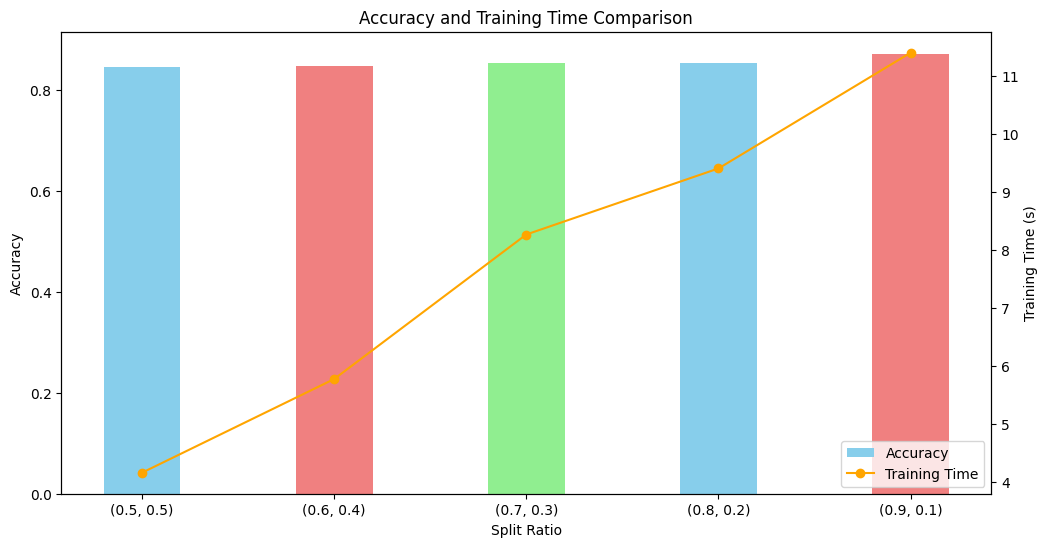

In [ ]:
ratios_plot(split_ratios, results_ratios_df)

**2. Khảo sát các giá trị của n_estimators và max-features**

In [ ]:
# Khảo sát các giá trị của n_estimators và max_features
n_estimators_values = [50, 100, 200]
max_features_values = ['log2', 'sqrt', 0.8, None]

results = []

for n_estimators in n_estimators_values:
    for max_features in max_features_values:
        accuracy, training_time = random_forest(X_train_tfidf, y_train, X_test_tfidf, y_test, n_estimators, max_features)
        results.append({'n_estimators': n_estimators, 'max_features': max_features, 'accuracy': accuracy, 'training_time': training_time})

# Hiển thị kết quả dưới dạng bảng
results_features_df = pd.DataFrame(results)
results_features_df

,n_estimators,max_features,accuracy,training_time
0,50,log2,0.821,2.390604
1,50,sqrt,0.854,5.441094
2,50,0.8,0.819,161.844269
3,50,None,0.820,194.089674
4,100,log2,0.854,4.646252
5,100,sqrt,0.871,10.866885
6,100,0.8,0.821,311.879978
7,100,None,0.817,386.930624
8,200,log2,0.867,9.730207
9,200,sqrt,0.872,21.823646


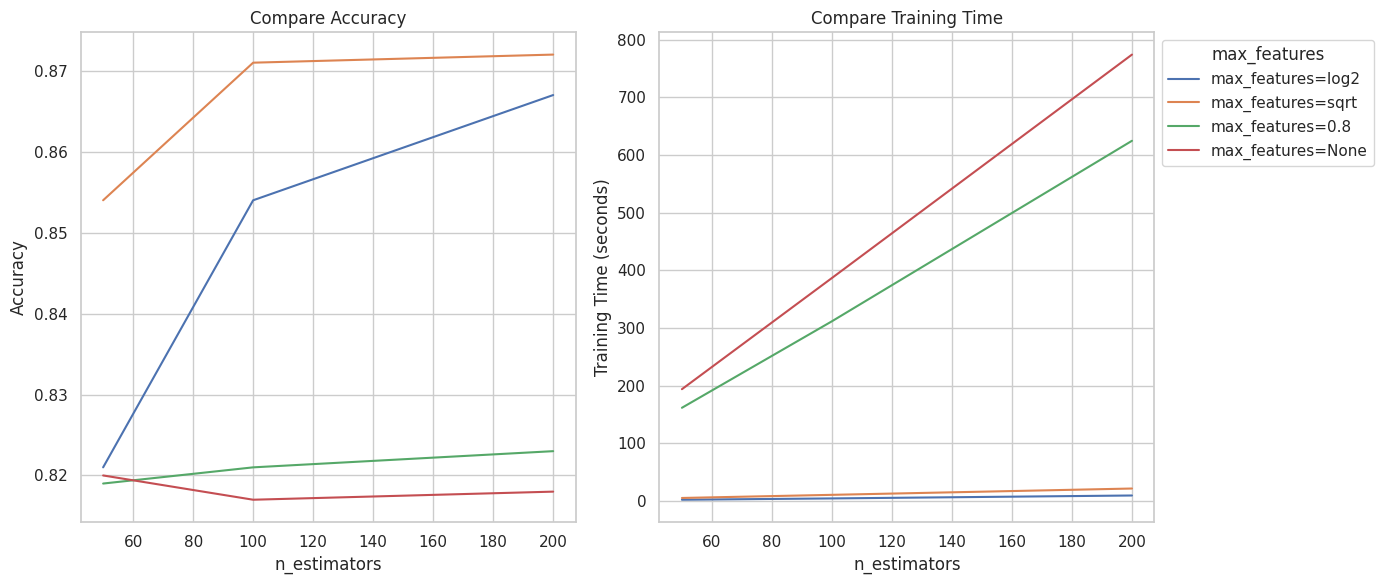

In [ ]:
# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Plot for Accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

for max_features_value in max_features_values:
    if max_features_value is None:
        subset = results_features_df[results_features_df['max_features'].isnull()]
        plt.plot(subset['n_estimators'], subset['accuracy'], label=f"max_features=None")
    else:
        subset = results_features_df[results_features_df['max_features'] == max_features_value]
        plt.plot(subset['n_estimators'], subset['accuracy'], label=f"max_features={max_features_value}")

plt.title('Compare Accuracy')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

# Plot for Training Time
plt.subplot(1, 2, 2)

for max_features_value in max_features_values:
    if max_features_value is None:
        subset = results_features_df[results_features_df['max_features'].isnull()]
        plt.plot(subset['n_estimators'], subset['training_time'], label=f"max_features=None")
    else:
        subset = results_features_df[results_features_df['max_features'] == max_features_value]
        plt.plot(subset['n_estimators'], subset['training_time'], label=f"max_features={max_features_value}")

plt.title('Compare Training Time')
plt.xlabel('n_estimators')
plt.ylabel('Training Time (seconds)')
plt.legend(title='max_features', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


# **Cài đặt và đánh giá Thuật toán SVM**

In [ ]:
def svm(X_train, y_train, X_test, y_test, **params):
    # Khởi tạo mô hình SVM
    svm_model = SVC(random_state=42, **params)

    # Huấn luyện mô hình
    start_time = time.time()
    svm_model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Dự đoán trên tập test
    y_test_pred = svm_model.predict(X_test)

    # Tính độ chính xác
    accuracy = accuracy_score(y_test, y_test_pred)

    return accuracy, training_time

Một số siêu tham số mà chúng ta có thể điều chỉnh để tối ưu hóa hiệu suất của thuật toán SVM:

1. **C (Regularization Parameter):**
- Số thực dương: điều chỉnh độ chặt của biên quyết định. Giá trị C lớn có thể dẫn đến một biên quyết định mềm hơn, nhưng có thể dẫn đến overfitting

2. **Kernel (Hạt nhân):**
- `linear`: hạt nhân tuyến tính
- `poly`: hạt nhân đa thức
- `rbf` hoặc 'gaussian': hạt nhân Radial basis function (RBF)
- `sigmoid`: hạt nhân sigmoid

3. **Max Iterations:**
- Số nguyên dương: số lần lặp tối đa cho việc tìm kiếm hội tụ

Trong phần này, chúng ta sẽ khảo sát *C* và *Kernel*.

**1. Khảo sát tỉ lệ phân chia  2 tập train/ test với C=1 và kernel='sigmoid'**

In [ ]:
# Khảo sát các tỉ lệ phân chia
split_ratios = [(0.5, 0.5), (0.6, 0.4), (0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]

results = []

for split_ratio in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(imdb_df['review'], imdb_df['label'], test_size=split_ratio[1], random_state=42)

    X_train_tfidf = vectorizer.transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    accuracy, training_time = svm(X_train_tfidf, y_train, X_test_tfidf, y_test, C=1.0, kernel='sigmoid')
    results.append({'split_ratio': split_ratio, 'accuracy': accuracy, 'training_time': training_time})

# Hiển thị kết quả dưới dạng bảng
results_ratios_df = pd.DataFrame(results)
results_ratios_df

,split_ratio,accuracy,training_time
0,"(0.5, 0.5)",0.866400,11.692604
1,"(0.6, 0.4)",0.869000,16.103639
2,"(0.7, 0.3)",0.867667,20.960233
3,"(0.8, 0.2)",0.874500,26.458996
4,"(0.9, 0.1)",0.887000,32.194148


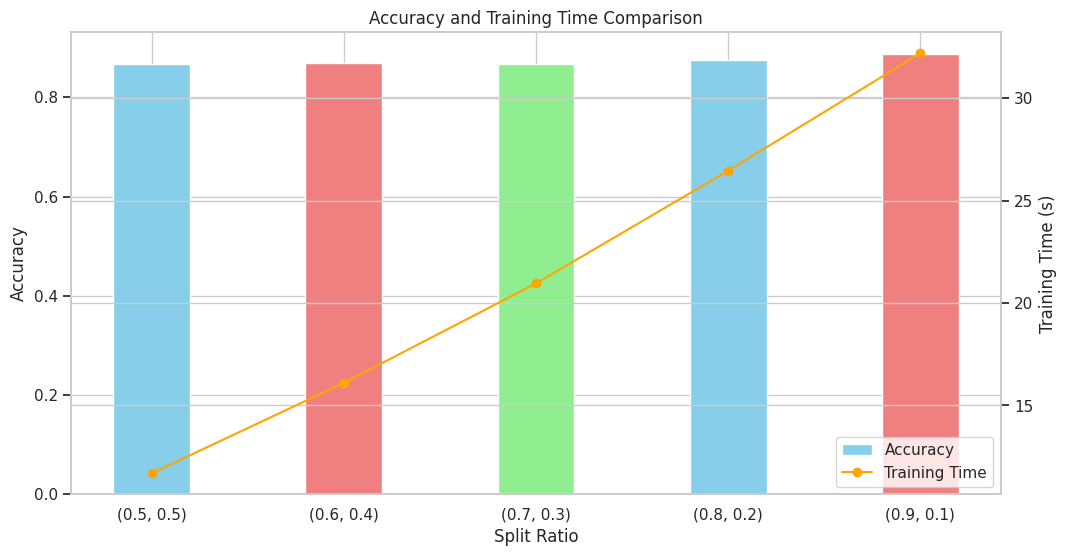

In [ ]:
ratios_plot(split_ratios, results_ratios_df)

**2. Khảo sát các giá trị của kernel**

In [ ]:
# Khảo sát các giá trị của kernel
C_values = [0.1, 1]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']

svm_results = []

for C in C_values:
    for kernel in kernel_values:
      accuracy, training_time = svm(X_train_tfidf, y_train, X_test_tfidf, y_test, C=C, kernel=kernel)
      svm_results.append({'C': C, 'kernel': kernel, 'accuracy': accuracy, 'training_time': training_time})

# Hiển thị kết quả dưới dạng bảng
results_svm_df = pd.DataFrame(svm_results)
results_svm_df

,C,kernel,accuracy,training_time
0,0.1,linear,0.865,51.133584
1,0.1,poly,0.485,65.552495
2,0.1,rbf,0.800,63.500158
3,0.1,sigmoid,0.867,52.097194
4,1.0,linear,0.889,33.667902
5,1.0,poly,0.836,143.768901
6,1.0,rbf,0.892,48.749016
7,1.0,sigmoid,0.887,32.059337


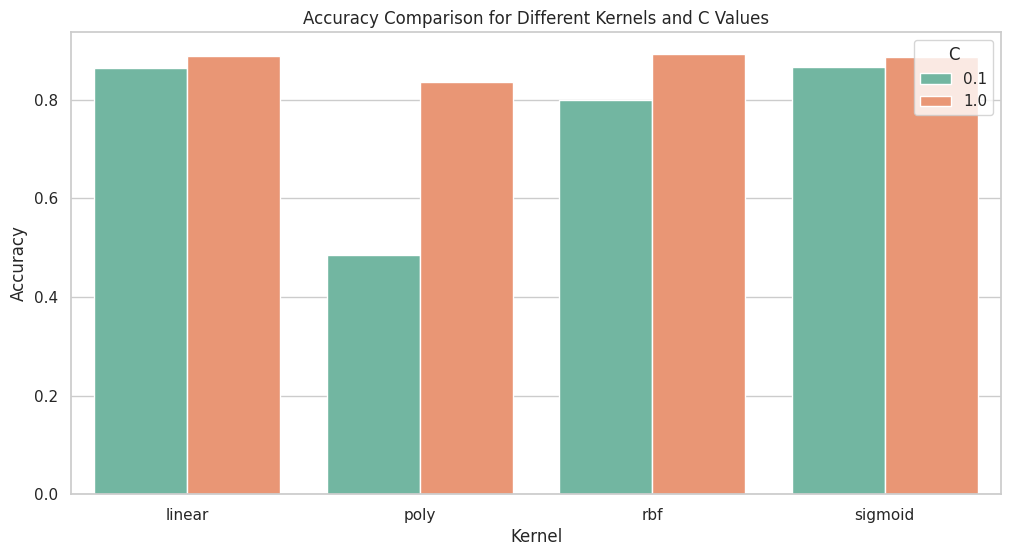

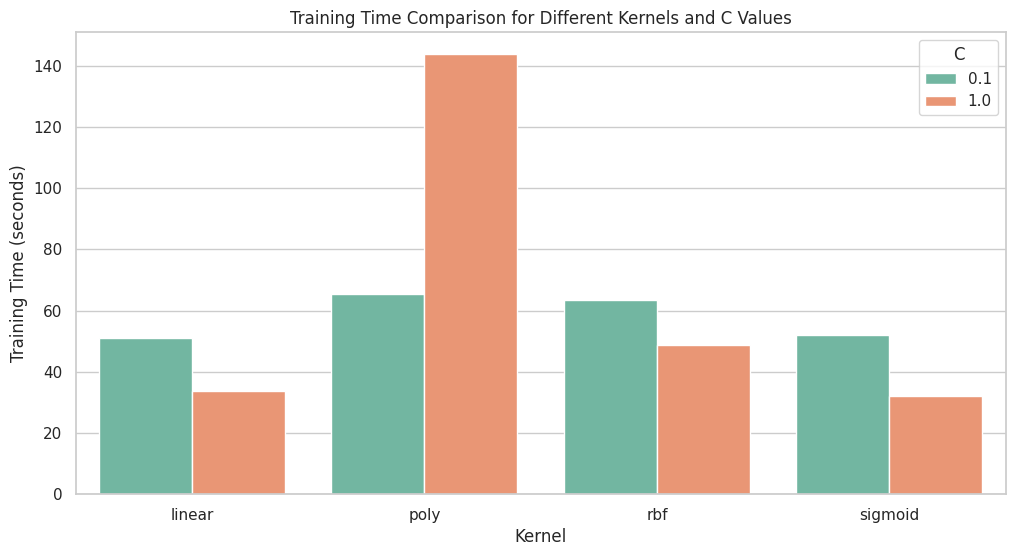

In [ ]:
# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Bar plot for Accuracy
plt.figure(figsize=(12, 6))
sns.barplot(x='kernel', y='accuracy', hue='C', data=results_svm_df, palette='Set2')
plt.title('Accuracy Comparison for Different Kernels and C Values')
plt.xlabel('Kernel')
plt.ylabel('Accuracy')
plt.legend(title='C')
plt.show()

# Bar plot for Training Time
plt.figure(figsize=(12, 6))
sns.barplot(x='kernel', y='training_time', hue='C', data=results_svm_df, palette='Set2')
plt.title('Training Time Comparison for Different Kernels and C Values')
plt.xlabel('Kernel')
plt.ylabel('Training Time (seconds)')
plt.legend(title='C')
plt.show()

# **Cài đặt và đánh giá Thuật toán CRF**

Install Required Libraries:

In [ ]:
!pip install sklearn-crfsuite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 5.6 MB/s eta 0:00:00


In [ ]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics

def train_crf(X_train, y_train, X_dev, y_dev, c1, c2, algorithm):
    # Khởi tạo mô hình CRF
    crf_model = sklearn_crfsuite.CRF(
        algorithm=algorithm,
        c1=c1,
        c2=c2,
        max_iterations=100,
        all_possible_transitions=True)

    # Huấn luyện mô hình
    start_time = time.time()
    crf_model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Dự đoán trên tập phát triển
    y_dev_pred = crf_model.predict(X_dev)

    # Tính độ chính xác
    accuracy = accuracy_score(y_dev, y_dev_pred)

    return accuracy, training_time

Một số siêu tham số mà chúng ta có thể điều chỉnh để tối ưu hóa hiệu suất của thuật toán CRF:

1. **c1 và c2 (Hệ số kiểm soát sự phức tạp của mô hình):**
- **c1** là kiểm soát trọng số của các tính năng đặc trưng (unary features)
- **c2** kiểm soát trọng số của các biểu diễn chuyển tiếp (pairwise features)

2. **algorithm (Thuật toán tối ưu hóa):**
- `lbfgs`: Limited-memory Broyden-Fletcher-Goldfarb-Shanno
- `l2sgd`: Stochastic Gradient Descent with L2 regularization
- `pa`: Passive Aggressive
- `arow`: Adaptive Regularization of Weights

3. **max_iterations (Số lần lặp tối đa):**
- Số lần lặp tối đa cho thuật toán tối ưu hóa

Trong phần này, chúng ta sẽ khảo sát *c1*, *c2* và *algorithm*.

**1. Khảo sát tỉ lệ phân chia  3 tập train/ dev/ test với c1=0.1, c2=0.2 và algorithm='lbfgs'**

# **Trình bày bảng kết quả đạt được.**
Bản nộp code sẽ cố định với các thông số hiện tại. Nhóm cần viết code để phát sinh bảng kết quả (các độ đo về chất lượng phân loại câu và thời gian xử lý của các mô hình)

In [ ]:
# Cố định các thông số từ khảo sát tốt nhất
# Bộ dữ liệu: train/test = 80/20
max_features_value = 5000
criterion_value = 'entropy'
n_estimators_value = 100
C_value = 1
kernel_value = 'rbf'

# Chọn độ đo chất lượng phân loại câu là accuracy (đánh giá trên tập test)
accuracy_dt, training_time_dt = decision_tree(X_train_tfidf, y_train, X_test_tfidf, y_test, max_features=max_features_value, criterion=criterion_value)
accuracy_rf, training_time_rf = random_forest(X_train_tfidf, y_train, X_test_tfidf, y_test, n_estimators=n_estimators_value, max_features=max_features_value)
accuracy_svm, training_time_svm = svm(X_train_tfidf, y_train, X_test_tfidf, y_test, C=C_value, kernel=kernel_value)

In [ ]:
data = {
    'Algorithm': ['Decision Tree', 'Random Forest', 'SVM'],
    'Training Time (s)': [training_time_dt, training_time_rf, training_time_svm],
    'Accuracy': [accuracy_dt, accuracy_rf, accuracy_svm]
}

df = pd.DataFrame(data)
print(df)

       Algorithm  Training Time (s)  Accuracy
0  Decision Tree           4.885558     0.715
1  Random Forest         402.950472     0.817
2            SVM          49.604257     0.892


# **Đánh giá kết quả**
Nhóm thực hiện chọn một tiêu chí khảo sát (vd: max-features của tf-idf, tỉ lệ phân bố data, ...) và viết code sinh ra biểu đồ (cột/đường/...) để thể hiện sự thay đổi về các độ đo chất lượng của các mô hình


**Tiêu chí khảo sát:** max-features của tf-idf ở mô hình Decision Tree (với max_features = 5000 và
criterion = 'entropy')

In [ ]:
max_features_tf_idf = [100, 500, 1000, 2000, 5000, 10000, 20000]

results = []

for max_feature in max_features_tf_idf:
    start_time = time.time()
    vectorizer = TfidfVectorizer(max_features=max_feature)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    accuracy, _ = decision_tree(X_train_tfidf, y_train, X_test_tfidf, y_test, max_features=5000, criterion='entropy')

    execute_time = time.time() - start_time
    results.append({
        'max_features_tf_idf': max_feature,
        'accuracy_test': accuracy,
        'execute_time': execute_time
    })

results_df = pd.DataFrame(results)
print(results_df)

   max_features_tf_idf  accuracy_test  execute_time
0                  100          0.645      2.145604
1                  500          0.697      3.742648
2                 1000          0.695      5.627994
3                 2000          0.697      9.708440
4                 5000          0.729     11.203441
5                10000          0.724      6.171803
6                20000          0.726      2.472250


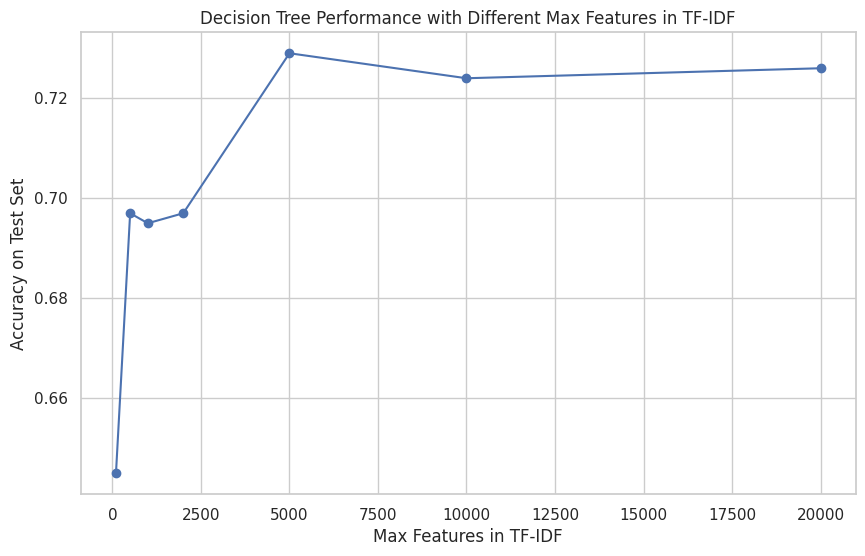

In [ ]:
# Plot for max_features in TF-IDF
plt.figure(figsize=(10, 6))
plt.plot(results_df['max_features_tf_idf'], results_df['accuracy_test'], marker='o')
plt.xlabel('Max Features in TF-IDF')
plt.ylabel('Accuracy on Test Set')
plt.title('Decision Tree Performance with Different Max Features in TF-IDF')
plt.show()

# **Phần mở rộng**
*Phần này không bắt buộc và sẽ trở thành phần cộng điểm dành cho nhóm nếu hoàn thành*

Trong phần này, các nhóm sẽ hoàn thiện một vài yêu cầu sau:


*   Viết chương trình nhằm download bộ word2vec hoặc tương tự
*   Viết hàm trích xuất biểu diễn câu từ bộ word2vec down được

```
# def extractSentence2Vec(sentence, word2vec) -> list/numpy.ndarray
Input:
    sentence - list of words
    word2vec - matrix of word embedding downloaded from the above part
Output: list of word vectors

Ex: input: sentence = ['a', 'b', 'c']
output: result = [[0, 1, 2], [1, 2, 3], [3, 4, 5]]

```






In [ ]:
import gensim.downloader

def downloadWord2vecModel(model_name='word2vec-google-news-300'):
    try:
        word2vec_model = gensim.downloader.load(model_name)
        return word2vec_model
    except Exception as e:
        print(f"Error downloading the word2vec model: {e}")
        return None

In [ ]:
def extractSentence2Vec(sentence, word2vec):
    result = []
    for word in sentence:
        if word in word2vec:
            result.append(word2vec[word])
    return result

In [ ]:
# Download word2vec model
word2vec_model = downloadWord2vecModel()

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Example sentence
input_sentence = ['a', 'b', 'c']

# Extract word vectors for the input sentence
result = extractSentence2Vec(input_sentence, word2vec_model)

print(result)

[array([-0.203125  ,  0.05322266,  0.109375  ,  0.21777344, -0.16210938,
        0.00509644, -0.23632812, -0.12597656,  0.01672363, -0.09863281,
       -0.11181641, -0.09814453, -0.16601562,  0.21289062, -0.16699219,
        0.02258301, -0.00334167,  0.109375  , -0.02856445,  0.11132812,
       -0.2578125 , -0.12890625,  0.06054688,  0.00549316,  0.14160156,
        0.05859375, -0.3203125 ,  0.03491211,  0.08789062,  0.24804688,
       -0.0534668 , -0.07763672, -0.08203125,  0.02392578, -0.20410156,
        0.13476562, -0.12402344,  0.12011719, -0.12695312,  0.17578125,
       -0.03100586,  0.04516602,  0.20214844,  0.03417969, -0.04199219,
       -0.05029297,  0.11474609, -0.27734375, -0.08984375, -0.0612793 ,
       -0.18359375,  0.328125  , -0.09082031,  0.11767578, -0.046875  ,
        0.16308594,  0.04785156, -0.15234375,  0.00970459, -0.18261719,
       -0.06030273, -0.13085938, -0.17871094, -0.19042969, -0.11914062,
       -0.30078125, -0.06030273,  0.13085938, -0.07080078, -0.1